# 9.1 - Testing API locally

In this notebook, we are testing our pipeline in order to check that the api pass the image as inference for our model before creating our Dash App. 

The configuration of the AWS Services are:

### AWS API Gateway

Steps:

- **Created a resource and named /detect-airplane**
- **Created a POST Method**

![data](images/api2.png)


- **We set as a Mapping template "application/jpeg"**
- **We set as template <code> {"image":"$.input.body"}</code> as we will pass the image with this body to our lambda*

![data](images/api3.png)

- **Last we enabled the *Binary Media Types* and specified <code>application/jpeg</code>**

![data](images/api4.png)

After that we are a ready to test the pipeline

### Testing POST request locally

In [1]:
import requests
import base64
import json
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg

In [2]:
# Endpoint of our API
endpoint_api = "https://grv4d32y32.execute-api.us-east-2.amazonaws.com/production_airplane/detect-airplane"

In [3]:
image_path = "../unzipped/validationImages/validation/data/019a3d18cb357cf3.jpg"  
with open(image_path, "rb") as image_file:
    encoded_image_data = bytearray(image_file.read())

headers = {'Content-Type': 'application/jpeg'}




response = requests.post(endpoint_api, data=encoded_image_data, headers=headers)

if response.status_code == 200:
    body_content = response.json()
    body_content_string = body_content['body']
    actual_detections_content = json.loads(body_content_string)
    actual_detections = actual_detections_content['detections']
    
else:
    print(f"Request failed with status code {response.status_code}: {response.text}")

In [4]:
actual_detections[:3]

[[0.0,
  0.524997353553772,
  0.027022868394851685,
  0.148856520652771,
  0.9673861265182495,
  0.9451823234558105],
 [0.0,
  0.3183800280094147,
  0.01076507568359375,
  0.018520206212997437,
  0.5892652273178101,
  0.3375087380409241],
 [0.0,
  0.23934787511825562,
  0.5806756019592285,
  0.5303872227668762,
  1.0,
  0.978328287601471]]

With this simple script be checked that our pipeline is working by sending the image as bytes to the lambda function and inferencing the model, sending back the predictions all through the API we built. Next step is to plot this predictions and be sure that our backend would be ready in order to proceed building our Dash App.

#### Plotting Image from POST request

In [5]:
# Function to plot the image

def draw_bounding_boxes_local(image_file, detections, threshold=0.3):
    image = mpimg.imread(image_file)
    plt.imshow(image)
    
    image_height, image_width = image.shape[:2]
    assigned_colors = dict()
    detected_count = 0
    
    for detection in detections:
        klass, score, x0, y0, x1, y1 = detection
        if score < threshold:
            continue
        
        detected_count += 1
        class_id = int(klass)
        
        if class_id not in assigned_colors:
            assigned_colors[class_id] = random.random(), random.random(), random.random()
            
        xmin = int(x0 * image_width)
        ymin = int(y0 * image_height)
        xmax = int(x1 * image_width)
        ymax = int(y1 * image_height)
        
        bounding_box = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor=assigned_colors[class_id],
            linewidth=2.5
        )
        
        plt.gca().add_patch(bounding_box)
        plt.gca().text(
            xmin,
            ymin - 2,
            "{:.3f}".format(score),
            bbox=dict(facecolor=(1, 0, 0, 1), alpha=0.5),
            color="white"
        )
    if detected_count > 1:
        print(f"Model detected {detected_count} airplane - Threshold: {threshold}")
        
    elif detected_count == 0:

        print(f"{detected_count} airplanes detected - Threshold: {threshold}")
        
    else:
        print(f"Model detected only {detected_count} airplane - Threshold: {threshold}")
        
    plt.show()

In [6]:
# Functions to inference the model via POST request

def get_detections_from_api(image_path, url):
    with open(image_path, "rb") as image_file:
        encoded_image_data = bytearray(image_file.read())

    headers = {'Content-Type': 'application/jpeg'}
    response = requests.post(url, data=encoded_image_data, headers=headers)

    if response.status_code == 200:
        body_content_string = response.json()['body']
        actual_detections_content = json.loads(body_content_string)
        actual_detections = actual_detections_content['detections']
        return actual_detections
    else:
        print(f"Request failed with status code {response.status_code}: {response.text}")
        return None

    
def plot_image_with_detections(image_path, url, threshold=0.3):
    detections = get_detections_from_api(image_path, url)
    if detections:
        draw_bounding_boxes_local(image_path, detections, threshold)


Model detected only 1 airplane - Threshold: 0.3


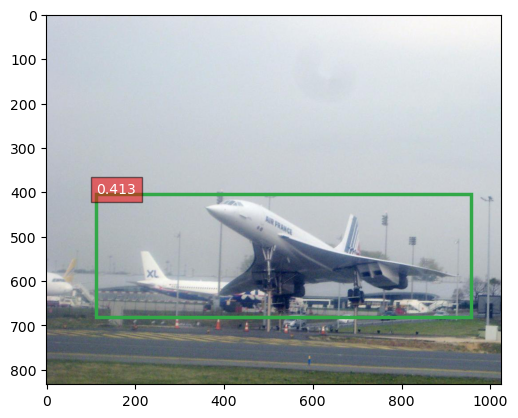

In [7]:
image_path = "../unzipped/validationImages/validation/data/0c15cbc55d7be54b.jpg"
plot_image_with_detections(image_path, endpoint_api, threshold=0.3)

Model detected only 1 airplane - Threshold: 0.3


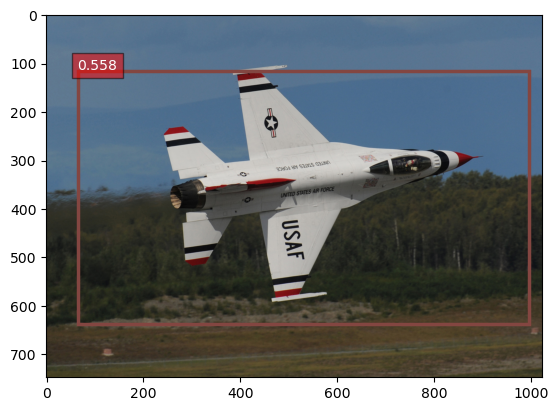

In [8]:
image_path = "../unzipped/validationImages/validation/data/062f77cb69a804c3.jpg"
plot_image_with_detections(image_path, endpoint_api, threshold=0.3)


With this implementation, we have been configured our backend for our interface app. Next step will be to build the Dash App.